# Evaluation


In [2]:
import sys
import os
sys.path.append('../') #act as if we are one directory higher so imports work 
import torch
from latent_to_timestep_model import LTT_model
from dataset import load_data_from_dir
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [6]:
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0"
latents, targets, conditions, unconditions = load_data_from_dir(data_folder=path, limit=200)


## LTT Model

In [30]:
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0/final_ltt_model.pt", 10
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train50-rv12-seed0/ltt_model.pt", 10

model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 10
model_path, steps  = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N7-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 7
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N5-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 5
# model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N3-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 3


ltt_model = LTT_model(steps=steps)
state_dict = torch.load(model_path, weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state

<All keys matched successfully>

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ltt_model))

19263606


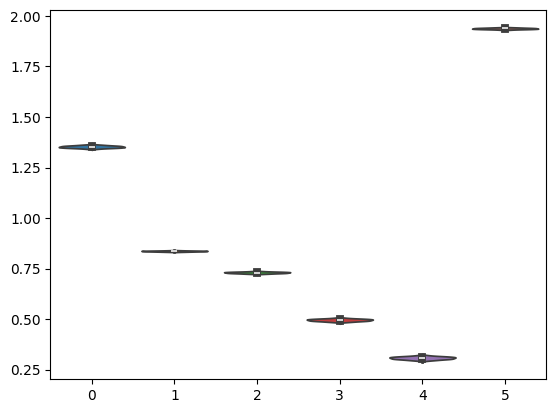

In [22]:
params_list = [ltt_model.forward(latent) for latent in latents]
params_list = torch.stack(params_list)

#visualize as violin plot over each of the 10 timesteps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params_list = params_list.detach().numpy()
params_list = params_list.reshape(-1, steps+1)
params_list = pd.DataFrame(params_list, columns=[f"{i}" for i in range(steps+1)])
sns.violinplot(data=params_list)
plt.show()


In [23]:
params_list

,0,1,2,3,4,5
0,1.350336,0.837728,0.732342,0.498624,0.311475,1.936432
1,1.358233,0.834756,0.727248,0.490541,0.301588,1.940877
2,1.348769,0.838312,0.733349,0.500238,0.313467,1.935513
3,1.363316,0.832843,0.723976,0.485341,0.295314,1.943601
4,1.355395,0.835828,0.729089,0.493436,0.305115,1.939316
...,...,...,...,...,...,...
195,1.361471,0.833524,0.725141,0.487252,0.297604,1.942613
196,1.352274,0.836993,0.731084,0.496648,0.309041,1.937544
197,1.343206,0.840403,0.736939,0.505943,0.320563,1.932175
198,1.354964,0.835978,0.729343,0.493899,0.305672,1.939063


### U-net encoding

In [31]:
# Create a dictionary to store the output
hook_storage = {}

# Define the hook function using a closure
def get_hook(storage):
    def hook_fn(module, input, output):
        storage["unet_output"] = output  # Store output in the dictionary
    return hook_fn
# Register the hook on the UNet
hook_handle = ltt_model.unet.register_forward_hook(get_hook(hook_storage))

# Run the forward pass
output = ltt_model.forward(latents[0])

# Retrieve the stored UNet output
unet_output = hook_storage["unet_output"]
print("Stored UNet Output:", unet_output.shape)




Stored UNet Output: torch.Size([1, 1024, 2, 2])


In [38]:
def mse(tensor1, tensor2):
    return torch.mean((tensor1 - tensor2) ** 2)

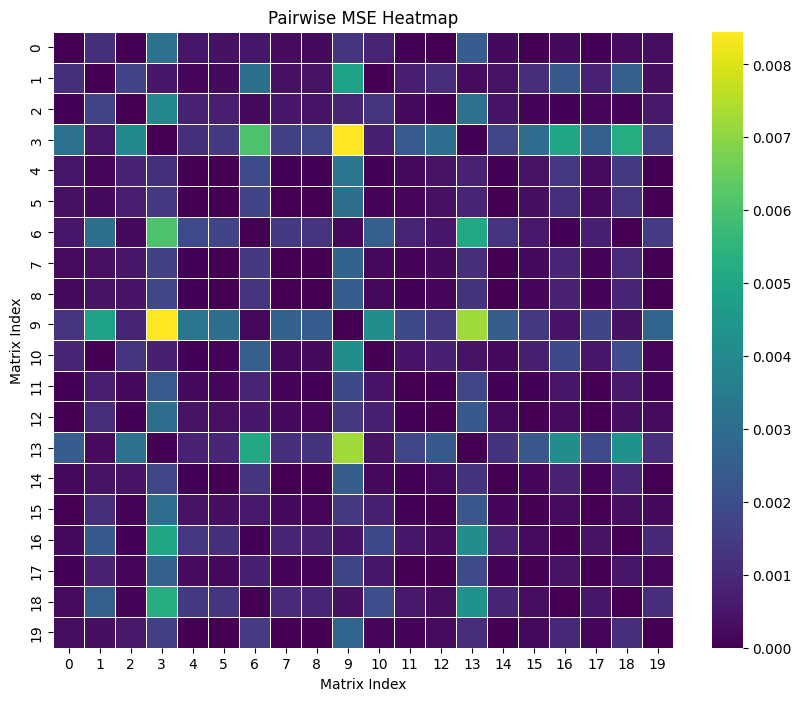

In [53]:
encodings = []
num_matrices = 20
for latent in latents[:num_matrices]:
    output = ltt_model.forward(latent)
    encodings.append(hook_storage["unet_output"])


mse_matrix = np.zeros((num_matrices, num_matrices))

for i in range(num_matrices):
    for j in range(num_matrices):
        mse_matrix[i, j] = mse(encodings[i], encodings[j])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mse_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()



In [54]:
encodings[1]

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[8.9047, 3.1766],
         [3.6043, 1.3548]],

        [[3.2127, 0.0000],
         [3.4294, 0.0000]]], grad_fn=<AsStridedBackward0>)

In [55]:
encodings[2]

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[8.6716, 3.0921],
         [3.5086, 1.3199]],

        [[3.1303, 0.0000],
         [3.3395, 0.0000]]], grad_fn=<AsStridedBackward0>)

## Optimal Timesteps

In [33]:
#load from torch.save(loss_matrix, os.path.join(args.data_dir, f"loss_matrix.pt"))
data_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/"
loss_matrix = torch.load(os.path.join(data_dir, f"loss_matrix.pt"))

/tmp/ipykernel_1728377/2229546449.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_matrix = torch.load(os.path.join(data_dir, f"loss_matrix.pt"))


In [34]:
loss_matrix

tensor([[0.2106, 0.1866, 0.1539,  ..., 0.0727, 0.0727, 0.0727],
        [0.1352, 0.1225, 0.1012,  ..., 0.0646, 0.0646, 0.0646],
        [0.1948, 0.1745, 0.1752,  ..., 0.0634, 0.0634, 0.0632],
        [0.3429, 0.3385, 0.3369,  ..., 0.0676, 0.0675, 0.0672],
        [0.1248, 0.1083, 0.0952,  ..., 0.0578, 0.0576, 0.0578],
        [0.1897, 0.1580, 0.1051,  ..., 0.0226, 0.0226, 0.0226]])

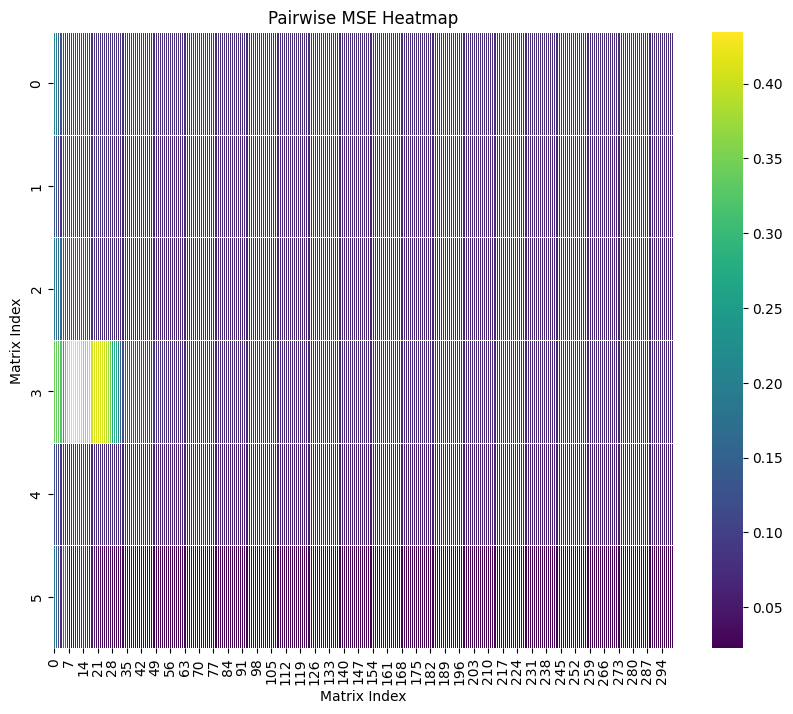

In [35]:
#plot loss matrix

plt.figure(figsize=(10, 8))
sns.heatmap(loss_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()

In [43]:
#find lowest loss matrix
min_loss = torch.min(loss_matrix, axis=1)
min_loss

torch.return_types.min(
values=tensor([0.0726, 0.0645, 0.0631, 0.0671, 0.0576, 0.0226]),
indices=tensor([197, 211, 185, 281, 203, 234]))

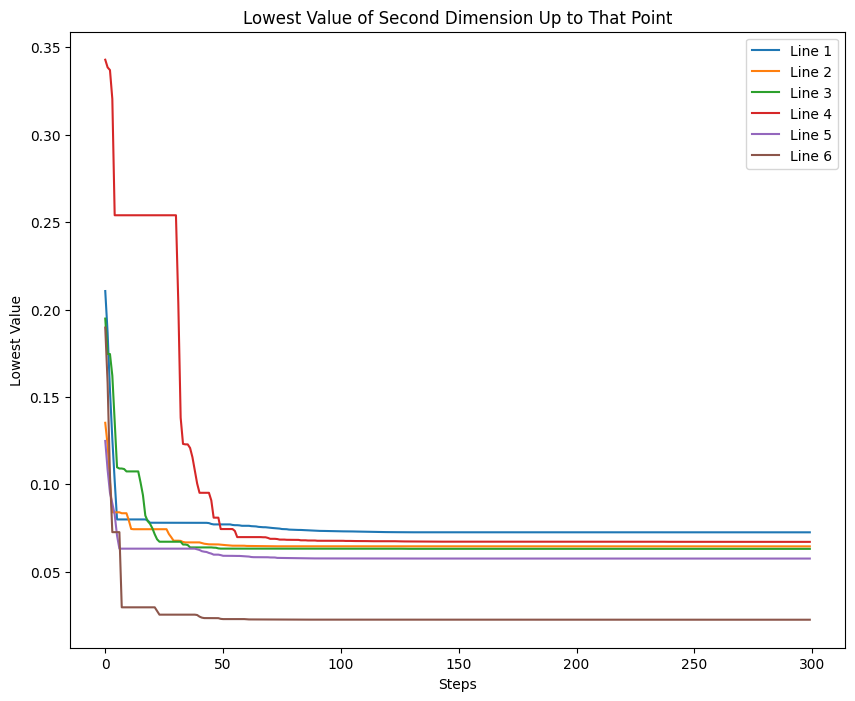

In [45]:
plt.figure(figsize=(10, 8))
for i in range(6):
    min_values = [torch.min(loss_matrix[i, :j+1,]).item() for j in range(300)]
    plt.plot(range(300), min_values, label=f'Line {i+1}')
plt.title("Lowest Value of Second Dimension Up to That Point")
plt.xlabel("Steps")
plt.ylabel("Lowest Value")
plt.legend()
plt.show()

In [36]:
gradient_matrix = torch.load(os.path.join(data_dir, f"loss_grad_matrix.pt"))
gradient_matrix.shape

/tmp/ipykernel_1728377/789086240.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gradient_matrix = torch.load(os.path.join(data_dir, f"loss_grad_matrix.pt"))


torch.Size([6, 300, 6])

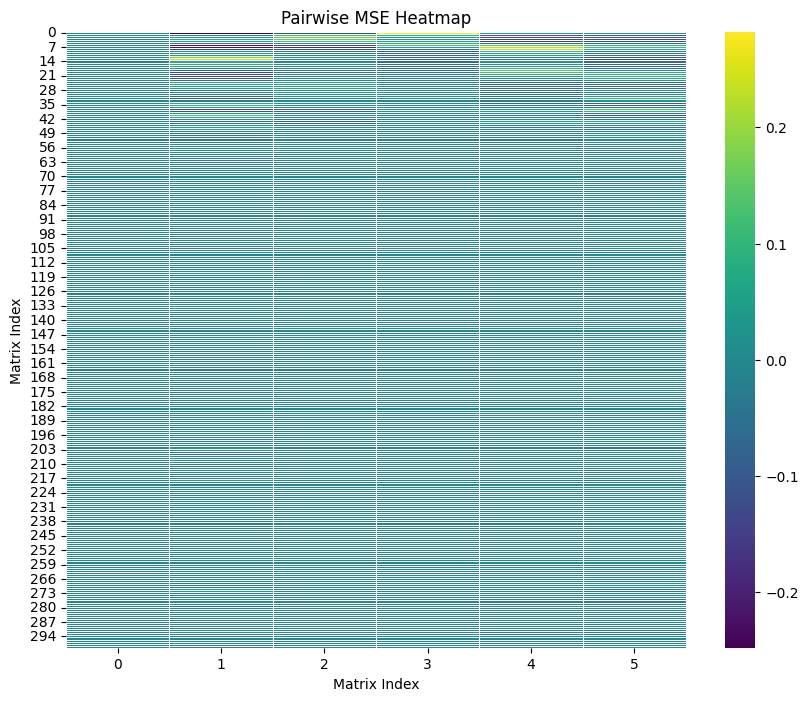

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(gradient_matrix[2], annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()


In [38]:
gradient_matrix[2, :, 0]


tensor([-1.2914e-07, -5.8903e-08,  3.3650e-08, -9.3969e-09, -1.2241e-07,
        -9.8934e-08, -1.8648e-07,  2.7661e-07, -9.1645e-08, -8.6136e-08,
         9.6680e-08, -6.5591e-08,  2.8441e-08,  3.8635e-08, -5.1411e-08,
         0.0000e+00, -5.7621e-08,  2.1154e-08,  7.4432e-08,  1.9827e-07,
        -3.8445e-08,  1.7693e-07,  1.2628e-07,  4.4204e-08, -1.3461e-07,
        -3.5693e-07,  3.4297e-07,  3.7393e-07, -2.2605e-07, -1.2706e-07,
        -1.2469e-07,  6.0534e-07,  1.4971e-07, -3.5531e-08,  3.9201e-07,
         2.0619e-07, -1.5861e-07, -3.5771e-08,  1.0496e-08, -3.2482e-08,
         4.0212e-07, -2.1788e-08, -2.8536e-07,  4.0900e-08,  1.1260e-07,
         1.6575e-07, -7.9020e-08,  6.4401e-08, -2.5459e-07, -5.9104e-08,
         2.8932e-08,  7.9444e-08,  4.8259e-07,  2.4309e-07,  1.7959e-07,
        -1.8819e-07,  1.3280e-07,  1.5643e-07,  1.0854e-07, -5.8803e-08,
        -1.2408e-07, -9.0237e-08,  4.4104e-08, -4.2098e-08,  3.8851e-08,
        -8.0747e-08,  5.0309e-08,  4.9942e-11,  1.7

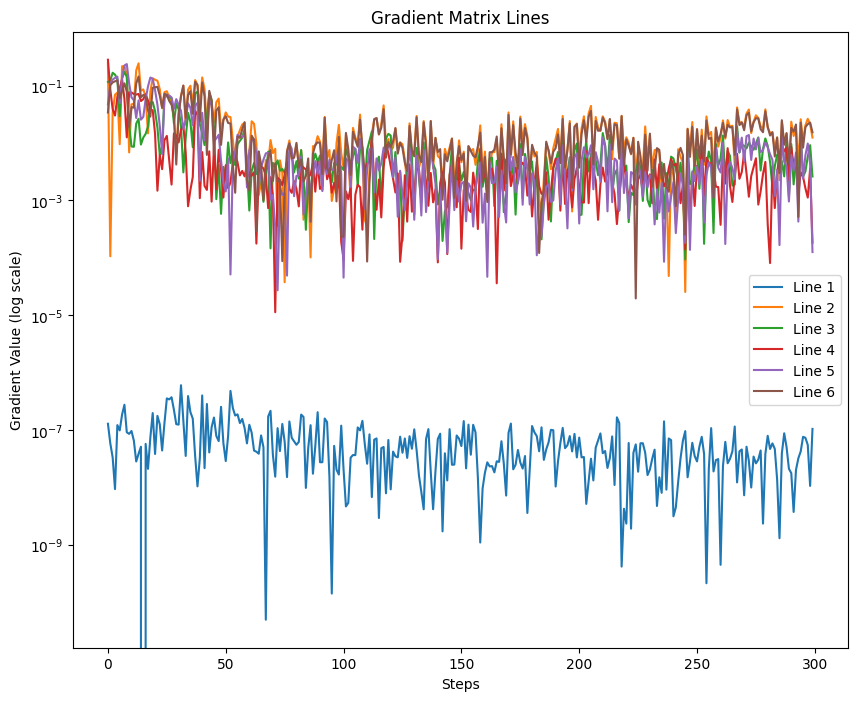

In [40]:
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(range(300), abs(gradient_matrix[2, :, i]), label=f'Line {i+1}')
plt.yscale('log')
plt.title("Gradient Matrix Lines")
plt.xlabel("Steps")
plt.ylabel("Gradient Value (log scale)")
plt.legend()
plt.show()
